# Регрессия для IC50

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Загружаем датасет
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Классическое МО/Курсовая/df_EDA.xlsx')

# Оставляем только целевую переменную IC50
df = df.drop(columns=['IC50, mM', 'CC50, mM', 'SI', 'CC50, mM_lg', 'SI_lg'])

# Для признаков оставляем все колонки, кроме целевой
X = df.drop(columns=['IC50, mM_lg'])

# Для целевой переменной берём только её
y = df['IC50, mM_lg']

Разделим датасет на тест и train

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train dataset size: {X_train.shape}, {y_train.shape}")
print(f"Test dataset size: {X_test.shape}, {y_test.shape}")

Train dataset size: (800, 192), (800,)
Test dataset size: (201, 192), (201,)


In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.7 MB/s eta 0:00:00


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.6 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Импортируются модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb
from catboost import CatBoostRegressor

# Разделение данных на обучающую и тестовую выборки (например, 80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создаем словарь моделей и их гиперпараметров
regressors = {
    "Линейная регрессия": {
        "модель": LinearRegression(),
        "параметры": {
            'copy_X': [True, False],
            'fit_intercept': [True, False],
            'n_jobs': [-1, 1],
            'positive': [True, False],
        }
    },
    "Случайный лес": {
        "модель": RandomForestRegressor(),
        "параметры": {
            'n_estimators': [50, 150, 250],
            'max_depth': [3, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
        }
    },
    "K ближайших соседей": {
        "модель": KNeighborsRegressor(),
        "параметры": {
            'n_neighbors': list(range(1, 21)),
            'weights': ['uniform', 'distance'],
        }
    },
    "XGBoost": {
        "модель": xgb.XGBRegressor(),
        "параметры": {
            'max_depth': [3, 6, 10],
            'n_estimators': [50, 100, 150],
        }
    },
    "CatBoost": {
        "модель": CatBoostRegressor(silent=True),
        "параметры": {
            'depth': [3, 6, 10],
            'iterations': [50, 100, 150],
        }
    }
}



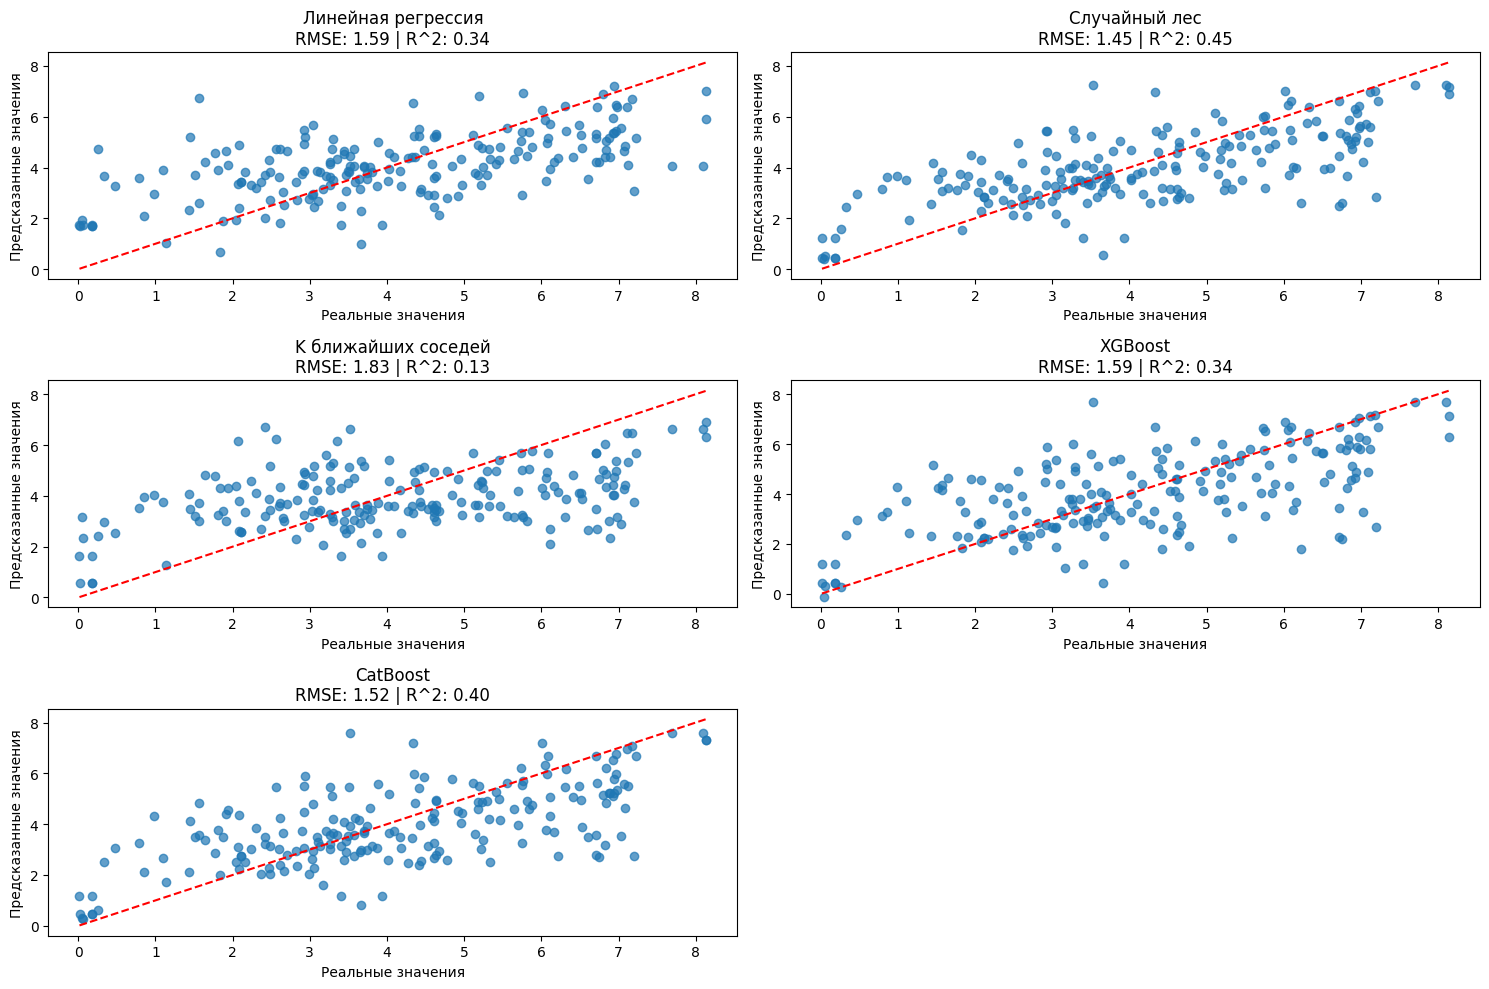

                Модель       MSE       MAE       R^2      RMSE
0   Линейная регрессия  2.527383  1.265464  0.340802  1.589774
1        Случайный лес  2.113319  1.130738  0.448799  1.453726
2  K ближайших соседей  3.334603  1.503037  0.130261  1.826089
3              XGBoost  2.533992  1.193058  0.339078  1.591852
4             CatBoost  2.307403  1.164973  0.398178  1.519014


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

results = []

plt.figure(figsize=(15, 10))
for i, (name, info) in enumerate(regressors.items(), 1):
    model = info['модель']
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)

    # Сохраняем результаты для таблицы
    results.append({
        'Модель': name,
        'MSE': mse,
        'MAE': mae,
        'R^2': r2,
        'RMSE': rmse
    })

    # Построение графика
    plt.subplot(3, 2, i)
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title(f'{name}\nRMSE: {rmse:.2f} | R^2: {r2:.2f}')
    plt.xlabel('Реальные значения')
    plt.ylabel('Предсказанные значения')

plt.tight_layout()
plt.show()

# Вывод таблицы с результатами
results_df = pd.DataFrame(results)
print(results_df)

На основе приведенных метрик лучше всего показывает себя Случайный лес:

MSE (среднеквадратичная ошибка): 2.11 — ниже, чем у остальных моделей (например, KNN — 3.33).

MAE (средняя абсолютная ошибка): 1.13 — низкая ошибка, показывает меньшие отклонения предсказаний.

R^2 (коэффициент детерминации): 0.4488 — лучший показатель среди всех моделей, говорит о том, что модель объясняет примерно 45% вариации целевой переменной.

RMSE (корень MSE): 1.45 — также лучший из представленных.

«Случайный лес» показывает наилучшие показатели по ошибкам и границе объяснения вариации (R^2).
Модель хорошо справляется с локальными зависимостями и объемом данных, она менее склонна к переобучению благодаря встроенной регуляризации.

## Производим подбор гиперпараметров

In [ ]:
from sklearn.model_selection import GridSearchCV

# Зафиксируем время начала выполнения
start_time = time.time()

# Создаем экземпляр регрессора с фиксированным сидом для воспроизводимости
forests = RandomForestRegressor(random_state=42)

# Задаем диапазон гиперпараметров для перебора
param_options = {
    'n_estimators': [50, 100, 150],              # число деревьев
    'max_depth': [6, 10, 15],                    # максимальная глубина дерева
    'min_samples_split': [2, 5, 10],             # минимальное число сэмплов для разделения узла
    'min_samples_leaf': [1, 2, 4],               # минимальное число сэмплов в листе
}

# Настраиваем поиск по сетке с кросс-валидацией
grid_cv = GridSearchCV(
    estimator=forests,
    param_grid=param_options,
    cv=5,
    n_jobs=-1,
    scoring='r2',
    verbose=2
)

# Обучаем модель с поиском лучших параметров
grid_cv.fit(X_train, y_train)

# Получение лучшей модели и результата поиска
optimal_model = grid_cv.best_estimator_
best_cv_score = grid_cv.best_score_

print(f"Лучшие параметры: {grid_cv.best_params_}")
print(f"Лучшая оценка R^2: {best_cv_score:.4f}")
print(f"Общее время выполнения: {time.time() - start_time:.2f} секунд")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150}
Лучшая оценка R^2: 0.3964
Общее время выполнения: 1055.16 секунд


лучших гиперпараметров:
1. max_depth = 10

Ограничивает глубину каждого дерева до десяти уровней.
Это способствует балансировке между сложностью модели и предотвращением переобучения.
Более глубокие деревья могут лучше запомнить сложные зависимости, но при этом повышают риск переобучения; ограничение глубины повышает стабильность и обобщающую способность.
2. min_samples_leaf = 1

Минимальное количество образцов в листовом узле — один.
Это делает модель максимально чувствительной к данным, позволяет деревьям “запоминать” локальные особенности.
В сочетании с другими параметрами, повышает точность, но увеличивает риск переобучения; предполагается, что при глубине 10 и общем числе деревьев это не критично.
3. min_samples_split = 10

Минимальное число образцов, необходимое для разбиения внутреннего узла — 10.
Ограничивает рост дерева, уменьшая вероятность сильного переобучения и увеличивая его устойчивость.
Помогает избежать слишком мелких разбиений на очень малых выборках, что способствует более обобщенной модели.
4. n_estimators = 150

Число деревьев в ансамбле — 150.
Больше деревьев обычно увеличивают стабильность и точность модели, но требуют больше времени на обучение.
В данном случае, это сбалансированный выбор, который обеспечивает хорошую точность без чрезмерного потребления ресурсов.

R² = 0.3964 — означает, что выбранная модель объясняет около 40% вариации целевой переменной на тестовых данных.
Это неплохо для задач регрессии, особенно если данные сложные и содержат много шума или нерегулярных зависимостей.
Хотя это не супер-отличный показатель, он свидетельствует о том, что модель уловила существенные закономерности.

## Предсказываем и оцениваем метрики

In [ ]:
# Предсказания на всех данных (X)
y_pred = optimal_model.predict(X)

# Вычисляем метрики по всей выборке
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mse)

print(f'Общая метрика R²: {r2:.4f}')
print(f'Общая MSE: {mse:.4f}')
print(f'Общая MAE: {mae:.4f}')
print(f'Общий RMSE: {rmse:.4f}')

Общая метрика R²: 0.7203
Общая MSE: 0.9672
Общая MAE: 0.7505
Общий RMSE: 0.9835


Общая метрика R² = 0.7203

Этот показатель, также известный как коэффициент детерминации, отображает долю вариации целевой переменной, объясненную моделью. Значение около 0.72 свидетельствует, что модель объясняет примерно 72% вариаций в данных — это достаточно хороший результат для задач регрессии в реальных сложных датасетах.

Иными словами, модель успешно находит общие закономерности и может предсказывать достаточно точно.

MSE (среднеквадратичная ошибка) = 0.9672

Это средняя квадратичная разность между предсказанными и реальными значениями. Число близкое к 1 — говорит, что в среднем ошибка предсказания примерно равна 1 (если шкала целевых переменных примерно в этом диапазоне).

Меньшее значение говорит о большей точности.

MAE (средняя абсолютная ошибка) = 0.7505

Этот показатель показывает средний абсолютный размах отклонений между предсказаниями и реальными значениями. Значение около 0.75 говорит о том, что в среднем ошибки составляют менее единицы по целевой переменной — что для многих практических задач считается достаточно хорошим результатом.

RMSE (корень из MSE) = 0.9835

Говорит о среднем отклонении в тех же единицах, что и целевой признак, — почти 1. Это подтверждает, что модель в большинстве случаев дает достаточно точные предсказания.

Итоговая оценка:
Модель показывает достаточно сильную предсказательную способность: объясняет значительную часть вариаций (72%), и средние ошибки — менее 1. Это хороший показатель для задачи регрессии, особенно если данные сложные или содержат шум. В целом, можно сказать, что модель успешно усвоила основные закономерности в данных.